In [ ]:
!pip install contractions

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import keras
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Embedding, GRU, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from utilities import *

sns.set_style('whitegrid');
sns.set_context('notebook', font_scale=1.1);

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
root = '/content/drive/My Drive/surely_not_sarcasm_data/'

# prepare data

In [5]:
df = pd.read_csv(root+'data/train_balanced_smaller.csv', usecols=['label', 'comment'])
df.head()

,label,comment
0,0,NC and NH.
1,0,You do know west teams play against west teams...
2,0,"They were underdogs earlier today, but since G..."
3,0,"This meme isn't funny none of the ""new york ni..."
4,0,I could use one of those tools.


In [7]:
X = df['comment'].values
y = df['label'].values

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, test_size=0.05, random_state=42)

In [9]:
X_train.shape, X_val.shape, X_test.shape

((768187,), (202155,), (40431,))

In [ ]:
# data = {}
# data['X_train'], data['X_val'], data['X_test'] = [preprocess_documents(x, root=root) for x in [X_train, X_val, X_test]]
# data['y_train'], data['y_val'], data['y_test'] = y_train, y_val, y_test

In [ ]:
# with open(root+'preprocessed_data_1503', 'wb') as file:
#     pickle.dump(data, file)

In [ ]:
# data = {}
# data['X_train'], data['X_val'], data['X_test'] = [preprocess_documents(x, root=root, twitter=True) for x in [X_train, X_val, X_test]]
# data['y_train'], data['y_val'], data['y_test'] = y_train, y_val, y_test

In [ ]:
# with open(root+'preprocessed_data_twitter_1503', 'wb') as file:
#     pickle.dump(data, file)

In [10]:
data = pickle.load(open(root+'preprocessed_data_1503', 'rb'))

# tokenize

In [11]:
input_dim = 10000
tokenizer = Tokenizer(num_words=input_dim, filters='')
tokenizer.fit_on_texts(data['X_train'])

In [12]:
X_train_tok = tokenizer.texts_to_sequences(data['X_train'])
X_val_tok = tokenizer.texts_to_sequences(data['X_val'])
X_test_tok = tokenizer.texts_to_sequences(data['X_test'])

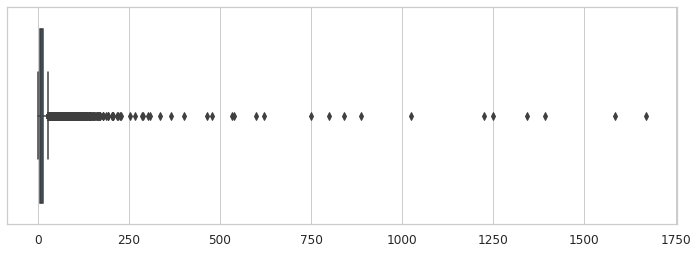

In [13]:
sen_len = [len(i) for i in X_train_tok]

plt.figure(figsize=(12,4))
sns.boxplot(x=sen_len);

In [14]:
np.quantile(sen_len, 0.9)

22.0

In [15]:
maxlen = 20

In [16]:
X_train_tok = pad_sequences(X_train_tok, padding='post', maxlen=maxlen)
X_val_tok = pad_sequences(X_val_tok, padding='post', maxlen=maxlen)
X_test_tok = pad_sequences(X_test_tok, padding='post', maxlen=maxlen)

In [17]:
y_train, y_val, y_test = data['y_train'], data['y_val'], data['y_test']

# non-pretrained embeddings

In [ ]:
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)

In [ ]:
model = Sequential([
    Embedding(input_dim=input_dim, output_dim=100, input_length=maxlen, mask_zero=True),
    GRU(100, dropout=0.4),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(X_train_tok, y_train, validation_data=(X_val_tok,y_val), batch_size=128, epochs=50, callbacks=[es])

Epoch 1/50
6002/6002 [==============================] - 481s 79ms/step - loss: 0.5613 - accuracy: 0.7075 - val_loss: 0.5434 - val_accuracy: 0.7227
Epoch 2/50
6002/6002 [==============================] - 472s 79ms/step - loss: 0.5324 - accuracy: 0.7311 - val_loss: 0.5346 - val_accuracy: 0.7286
Epoch 3/50
6002/6002 [==============================] - 466s 78ms/step - loss: 0.5166 - accuracy: 0.7424 - val_loss: 0.5309 - val_accuracy: 0.7308
Epoch 4/50
6002/6002 [==============================] - 477s 79ms/step - loss: 0.5042 - accuracy: 0.7512 - val_loss: 0.5321 - val_accuracy: 0.7312
Epoch 5/50
6002/6002 [==============================] - 476s 79ms/step - loss: 0.4932 - accuracy: 0.7589 - val_loss: 0.5330 - val_accuracy: 0.7322
Epoch 6/50
6002/6002 [==============================] - 472s 79ms/step - loss: 0.4841 - accuracy: 0.7645 - val_loss: 0.5369 - val_accuracy: 0.7311


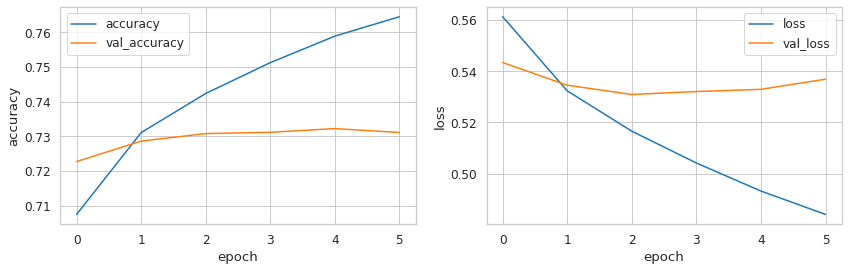

In [ ]:
plot_history(fit)

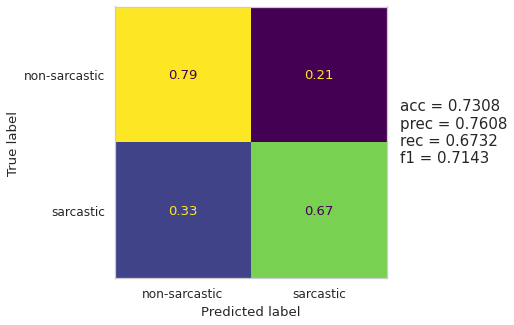

In [ ]:
evaluate(model, X_val_tok, y_val)

In [ ]:
show_errors(tokenizer, model, X_val, X_val_tok, y_val, n=5)

False negatives:
---------------------------
I'll take Rasho and day.
Then I guess you are shit face.
It's funny in an ironic way.
367M credits, yeah I can grind that
Of course not, it's an ornament now.

False positives:
---------------------------
Just park them over there, by those tanks we've repeatedly told you we don't need.
Viva El Donald!
Is that the AR-15 killing machine gat firing over 800 gats per second?
3RD Q , U WILL NEVER KNOW WHEN U GET HIT BY IT.
la encarnacion del no future


In [ ]:
model.save(root+'gru')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/gru/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/gru/assets


# pretrained embeddings: non-trainable

In [18]:
vec_len = 100

In [19]:
wordemb = WordEmbeddings()
embedding_matrix = wordemb.get_glove_embeddings(input_dim, vec_len, tokenizer, root=root)

coverage: 0.9815


In [ ]:
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)

In [ ]:
model = Sequential([
    Embedding(input_dim=input_dim, output_dim=100, input_length=maxlen, mask_zero=True,
              weights=[embedding_matrix], trainable=False),
    GRU(100, dropout=0.4),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(X_train_tok, y_train, validation_data=(X_val_tok,y_val), batch_size=128, epochs=50, callbacks=[es])

Epoch 1/50
6002/6002 [==============================] - 452s 73ms/step - loss: 0.6071 - accuracy: 0.6628 - val_loss: 0.5679 - val_accuracy: 0.7008
Epoch 2/50
6002/6002 [==============================] - 433s 72ms/step - loss: 0.5773 - accuracy: 0.6918 - val_loss: 0.5593 - val_accuracy: 0.7079
Epoch 3/50
6002/6002 [==============================] - 435s 73ms/step - loss: 0.5678 - accuracy: 0.7001 - val_loss: 0.5496 - val_accuracy: 0.7164
Epoch 4/50
6002/6002 [==============================] - 430s 72ms/step - loss: 0.5626 - accuracy: 0.7049 - val_loss: 0.5462 - val_accuracy: 0.7189
Epoch 5/50
6002/6002 [==============================] - 429s 71ms/step - loss: 0.5598 - accuracy: 0.7069 - val_loss: 0.5463 - val_accuracy: 0.7191
Epoch 6/50
6002/6002 [==============================] - 427s 71ms/step - loss: 0.5576 - accuracy: 0.7091 - val_loss: 0.5430 - val_accuracy: 0.7220
Epoch 7/50
6002/6002 [==============================] - 423s 71ms/step - loss: 0.5554 - accuracy: 0.7107 - val_loss: 0

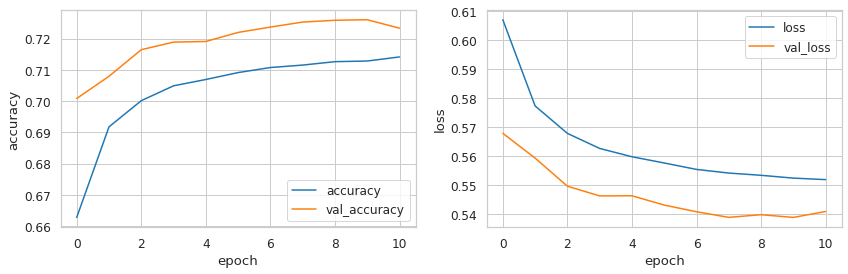

In [ ]:
plot_history(fit)

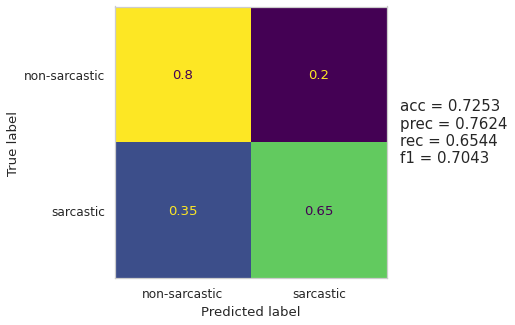

In [ ]:
evaluate(model, X_val_tok, y_val)

In [ ]:
show_errors(tokenizer, model, X_val, X_val_tok, y_val, n=5)

False negatives:
---------------------------
As an American, what the fuck is a gram?
I'd rather spend tax money on a bloated military than use it for something constructive like helping other Americans (And myself)
Why would I pirate when I could conveniently buy a blue ray for $30, six months after the movie is in theaters?
9 &amp; 7, those numbers might mean something this year..I can't put my finger on it
Luckily Europe isn't as diverse.

False positives:
---------------------------
Can't have pesky reporters filming what they are planning to do...
I bet the driver appreciated the flash while driving at night.
ehh, he used to be funny
The great thing about this one is that the GOP cannot change their position on this any time soon.
Don't forget binding of Isaac


# pretrained embeddings: trainable

In [ ]:
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)

In [ ]:
model = Sequential([
    Embedding(input_dim=input_dim, output_dim=100, input_length=maxlen, mask_zero=True,
              weights=[embedding_matrix], trainable=True),
    GRU(100, dropout=0.4),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(X_train_tok, y_train, validation_data=(X_val_tok,y_val), batch_size=128, epochs=50, callbacks=[es])

Epoch 1/50
6002/6002 [==============================] - 310s 51ms/step - loss: 0.5694 - accuracy: 0.6995 - val_loss: 0.5385 - val_accuracy: 0.7261
Epoch 2/50
6002/6002 [==============================] - 310s 52ms/step - loss: 0.5354 - accuracy: 0.7281 - val_loss: 0.5278 - val_accuracy: 0.7340
Epoch 3/50
6002/6002 [==============================] - 311s 52ms/step - loss: 0.5227 - accuracy: 0.7375 - val_loss: 0.5228 - val_accuracy: 0.7383
Epoch 4/50
6002/6002 [==============================] - 311s 52ms/step - loss: 0.5135 - accuracy: 0.7441 - val_loss: 0.5208 - val_accuracy: 0.7403
Epoch 5/50
6002/6002 [==============================] - 312s 52ms/step - loss: 0.5056 - accuracy: 0.7503 - val_loss: 0.5222 - val_accuracy: 0.7397
Epoch 6/50
6002/6002 [==============================] - 317s 53ms/step - loss: 0.4995 - accuracy: 0.7543 - val_loss: 0.5208 - val_accuracy: 0.7406
Epoch 7/50
6002/6002 [==============================] - 313s 52ms/step - loss: 0.4942 - accuracy: 0.7581 - val_loss: 0

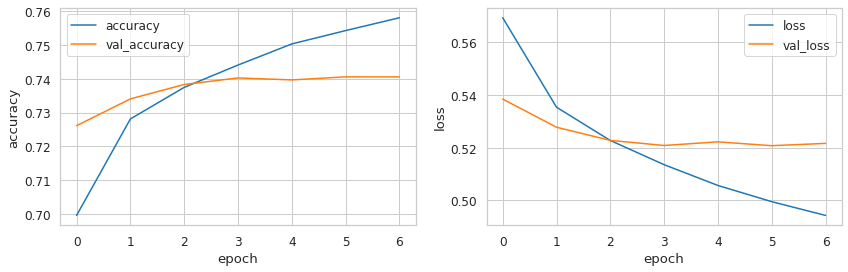

In [ ]:
plot_history(fit)

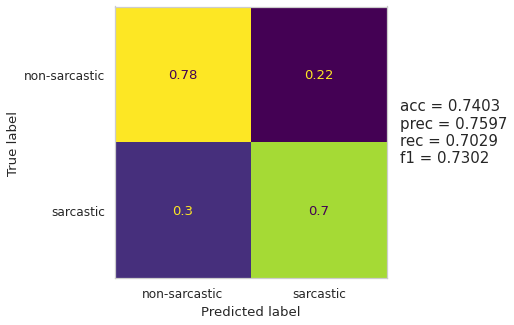

In [ ]:
evaluate(model, X_val_tok, y_val)

In [ ]:
show_errors(model, X_val, X_val_tok, y_val, n=5)

False negatives:
---------------------------
Or even better just don't listen to music
And not with his hand...
Not true, according my extensive experience in one semester of Marketing
Get it BC shoe laces hahah omg lol
Ebola-patienten in West-Afrika begonnen gelijk met het inzamelen van geld en eten, toen ze van de verschrikkingen van deze reizigers hoorden.

False positives:
---------------------------
I wonder where Bill Clinton was and what he was doing...
Good News Everyone!
Did you try to a hard reboot?
Way easier to pull off with a gi, takes some serious talent to hit it in an MMA fight with no garment to grab onto
Looks like a ragdoll glitch


In [ ]:
model.save(root+'gru_glove100_trainable')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/gru_glove100_trainable/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/gru_glove100_trainable/assets


# embeddings regularization
ran: 18.03.2022

In [21]:
model = Sequential([
    Embedding(input_dim=input_dim, output_dim=100, input_length=maxlen, mask_zero=True,
              weights=[embedding_matrix], trainable=True, embeddings_regularizer=tf.keras.regularizers.L1L2(l1=1e-6, l2=1e-6)),
    GRU(100, dropout=0.4),
    Dense(1, activation='sigmoid')
])

es = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=3, restore_best_weights=True)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(X_train_tok, y_train, validation_data=(X_val_tok,y_val), batch_size=128, epochs=50, callbacks=[es])

Epoch 1/50
6002/6002 [==============================] - 267s 43ms/step - loss: 0.8025 - accuracy: 0.7005 - val_loss: 0.6599 - val_accuracy: 0.7242
Epoch 2/50
6002/6002 [==============================] - 255s 43ms/step - loss: 0.6280 - accuracy: 0.7271 - val_loss: 0.5991 - val_accuracy: 0.7348
Epoch 3/50
6002/6002 [==============================] - 256s 43ms/step - loss: 0.5894 - accuracy: 0.7352 - val_loss: 0.5814 - val_accuracy: 0.7349
Epoch 4/50
6002/6002 [==============================] - 258s 43ms/step - loss: 0.5719 - accuracy: 0.7405 - val_loss: 0.5688 - val_accuracy: 0.7403
Epoch 5/50
6002/6002 [==============================] - 256s 43ms/step - loss: 0.5620 - accuracy: 0.7456 - val_loss: 0.5671 - val_accuracy: 0.7405
Epoch 6/50
6002/6002 [==============================] - 257s 43ms/step - loss: 0.5559 - accuracy: 0.7489 - val_loss: 0.5640 - val_accuracy: 0.7422
Epoch 7/50
6002/6002 [==============================] - 263s 44ms/step - loss: 0.5512 - accuracy: 0.7537 - val_loss: 0

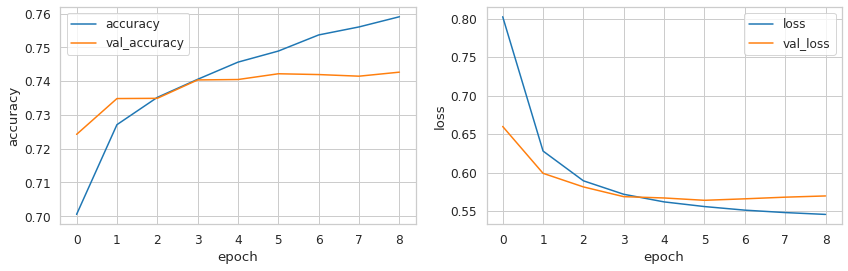

In [22]:
plot_history(fit)

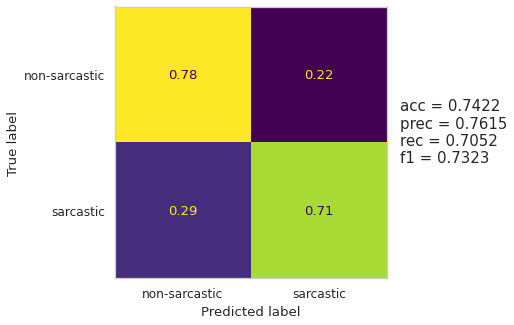

In [23]:
evaluate(model, X_val_tok, y_val)

In [24]:
show_errors(model, X_val, X_val_tok, y_val, n=5)

False negatives:
---------------------------
I weep for this generation.
Shutter speed of the camera that filmed the gif in affect, just looks slow
Lose 10 in a row
So this is where people get reincarnated who've been told they'll have a school of virgins when they die.
What do shoes have to do with this....?

False positives:
---------------------------
Nah because they won't even make it to the league in the first place.
Maybe 10, so they can run a full squad at least?
I have to pay to get good deals and to play with friends
Well he's dead if that's what you're asking.
wait, so reddit is SFGate's source for news now?


In [25]:
model.save(root+'gru_glove100_regularized')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/gru_glove100_regularized/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/gru_glove100_regularized/assets


In [28]:
y_pred = model.predict(X_val_tok)

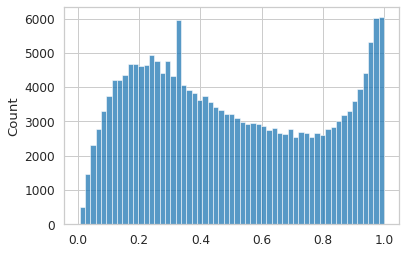

In [30]:
sns.histplot(x=y_pred.flatten());

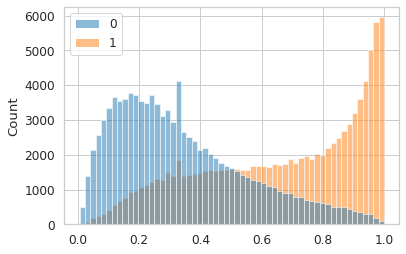

In [31]:
sns.histplot(x=y_pred.flatten(), hue=y_val);

In [33]:
thresholds = np.arange(0, 1, 0.01)
f1_scores = [f1_score(y_val, y_pred > thr) for thr in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]
best_threshold

0.37

In [34]:
thresholds = np.arange(0, 1, 0.01)
f1_scores = [accuracy_score(y_val, y_pred > thr) for thr in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]
best_threshold

0.51

In [ ]:
model = Sequential([
    Embedding(input_dim=input_dim, output_dim=100, input_length=maxlen, mask_zero=True,
              weights=[embedding_matrix], trainable=True, embeddings_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-5)),
    GRU(100, dropout=0.4),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(X_train_tok, y_train, validation_data=(X_val_tok,y_val), batch_size=128, epochs=50, callbacks=[es])

Epoch 1/50
6002/6002 [==============================] - 475s 78ms/step - loss: 1.2179 - accuracy: 0.6947 - val_loss: 0.6393 - val_accuracy: 0.7171
Epoch 2/50
6002/6002 [==============================] - 466s 78ms/step - loss: 0.6294 - accuracy: 0.7160 - val_loss: 0.6136 - val_accuracy: 0.7250
Epoch 3/50
6002/6002 [==============================] - 467s 78ms/step - loss: 0.6163 - accuracy: 0.7227 - val_loss: 0.6097 - val_accuracy: 0.7283
Epoch 4/50
6002/6002 [==============================] - 461s 77ms/step - loss: 0.6130 - accuracy: 0.7271 - val_loss: 0.6075 - val_accuracy: 0.7315
Epoch 5/50
6002/6002 [==============================] - 466s 78ms/step - loss: 0.6118 - accuracy: 0.7292 - val_loss: 0.6073 - val_accuracy: 0.7338
Epoch 6/50
6002/6002 [==============================] - 470s 78ms/step - loss: 0.6119 - accuracy: 0.7309 - val_loss: 0.6072 - val_accuracy: 0.7354
Epoch 7/50
6002/6002 [==============================] - 491s 82ms/step - loss: 0.6123 - accuracy: 0.7328 - val_loss: 0

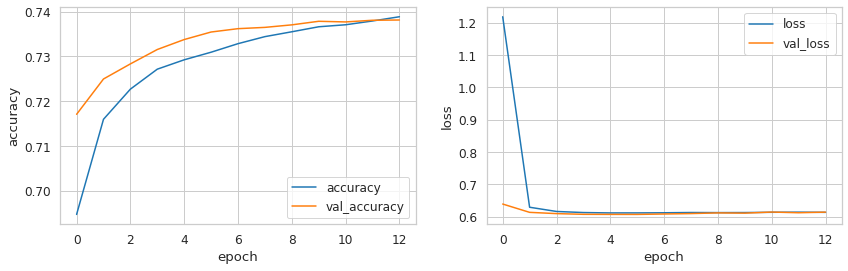

In [ ]:
plot_history(fit)

# freezing
ran: 18.03.2022

In [35]:
vec_len = 100

In [36]:
wordemb = WordEmbeddings()
embedding_matrix = wordemb.get_glove_embeddings(input_dim, vec_len, tokenizer, root=root)

coverage: 0.9815


In [37]:
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)

In [38]:
embedding_layer = Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
                            mask_zero=True, weights=[embedding_matrix])
embedding_layer.trainable = False

In [39]:
model = Sequential([
    embedding_layer,
    GRU(100, dropout=0.4),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(X_train_tok, y_train, validation_data=(X_val_tok,y_val), batch_size=128, epochs=50, callbacks=[es])

Epoch 1/50
6002/6002 [==============================] - 249s 41ms/step - loss: 0.6072 - accuracy: 0.6631 - val_loss: 0.5783 - val_accuracy: 0.6906
Epoch 2/50
6002/6002 [==============================] - 244s 41ms/step - loss: 0.5783 - accuracy: 0.6912 - val_loss: 0.5589 - val_accuracy: 0.7077
Epoch 3/50
6002/6002 [==============================] - 245s 41ms/step - loss: 0.5682 - accuracy: 0.7001 - val_loss: 0.5504 - val_accuracy: 0.7153
Epoch 4/50
6002/6002 [==============================] - 241s 40ms/step - loss: 0.5635 - accuracy: 0.7041 - val_loss: 0.5476 - val_accuracy: 0.7182
Epoch 5/50
6002/6002 [==============================] - 242s 40ms/step - loss: 0.5605 - accuracy: 0.7063 - val_loss: 0.5427 - val_accuracy: 0.7214
Epoch 6/50
6002/6002 [==============================] - 245s 41ms/step - loss: 0.5575 - accuracy: 0.7091 - val_loss: 0.5419 - val_accuracy: 0.7217
Epoch 7/50
6002/6002 [==============================] - 243s 41ms/step - loss: 0.5559 - accuracy: 0.7104 - val_loss: 0

In [41]:
embedding_layer.trainable = True
adam = tf.keras.optimizers.Adam(0.0005)

In [42]:
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
fit2 = model.fit(X_train_tok, y_train, validation_data=(X_val_tok,y_val), batch_size=128, epochs=30, callbacks=[es])

Epoch 1/30
6002/6002 [==============================] - 267s 44ms/step - loss: 0.5422 - accuracy: 0.7218 - val_loss: 0.5275 - val_accuracy: 0.7338
Epoch 2/30
6002/6002 [==============================] - 263s 44ms/step - loss: 0.5298 - accuracy: 0.7318 - val_loss: 0.5239 - val_accuracy: 0.7364
Epoch 3/30
6002/6002 [==============================] - 261s 43ms/step - loss: 0.5226 - accuracy: 0.7376 - val_loss: 0.5203 - val_accuracy: 0.7388
Epoch 4/30
6002/6002 [==============================] - 262s 44ms/step - loss: 0.5164 - accuracy: 0.7419 - val_loss: 0.5190 - val_accuracy: 0.7404
Epoch 5/30
6002/6002 [==============================] - 273s 45ms/step - loss: 0.5119 - accuracy: 0.7452 - val_loss: 0.5182 - val_accuracy: 0.7411
Epoch 6/30
6002/6002 [==============================] - 262s 44ms/step - loss: 0.5079 - accuracy: 0.7483 - val_loss: 0.5187 - val_accuracy: 0.7407
Epoch 7/30
6002/6002 [==============================] - 264s 44ms/step - loss: 0.5045 - accuracy: 0.7501 - val_loss: 0

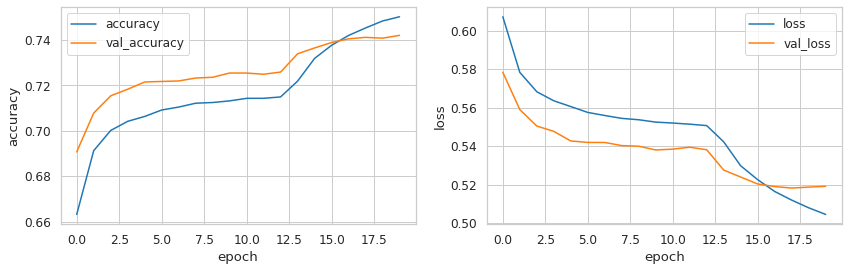

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(14,4))

for i, which in enumerate(['accuracy', 'loss']):
    ax = axes[i]
    ax.plot(fit.history[which]+fit2.history[which], label=which)
    ax.plot(fit.history['val_'+which]+fit2.history['val_'+which], label='val_'+which)
    ax.set_xlabel('epoch')
    ax.set_ylabel(which)
    ax.legend();

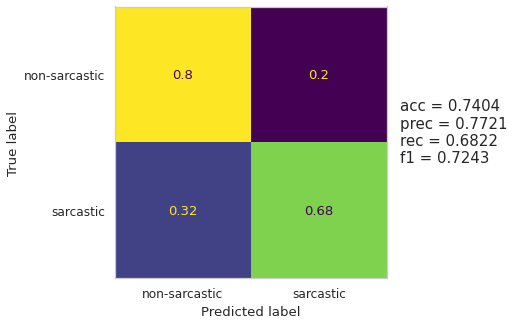

In [44]:
evaluate(model, X_val_tok, y_val)

In [46]:
show_errors(model, X_val, X_val_tok, y_val, n=5)

False negatives:
---------------------------
Tebow's available.
We really out there
Maybe this is a good example for Dems to argue that double action revolvers need to be regulated to fewer than 6 rounds in the cylinders.
Techies picker, what did you expect ?
Just like how the Egypt today is the country that built the pyramids because they live where other guys lived millenia ago.

False positives:
---------------------------
He tried to join ISIS, thats his crime in my book
this sounds hilarious
This would also kill crit hacks, I can't see anything wrong with that happening.
Mei players know exactly what they are doing
Use them When you feel underpowered and in need of new gear


In [47]:
model.save(root+'gru_freeze_unfreeze')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/gru_freeze_unfreeze/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/gru_freeze_unfreeze/assets
